In [1]:
import pandas as pd
import json
import numpy as np
import seaborn as sn
import pickle

from matplotlib import pyplot as plt
from io import StringIO
%matplotlib inline

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import auc, roc_auc_score,f1_score, confusion_matrix, roc_curve

from tqdm.auto import tqdm
from sklearn.model_selection import KFold

In [3]:
###Data Cleanup and EDA####

In [ ]:
df_movies =  pd.read_csv('Data/5kMovies.csv')
df_credits = pd.read_csv('Data/5kCredits.csv')

In [45]:
df_tmdb = pd.concat([df_movies, df_credits], axis=1)

In [46]:
new_column_order = ['id', 'title', 'original_language','genres', 'release_date','runtime', 'popularity', 'vote_count', 'vote_average', 'budget', 'revenue']
genres_list = ['Action', 'Adventure', 'Fantasy', 'Science Fiction', 'Thriller', 'Comedy']

In [47]:
def data_cleanup(df, new_columns):
    df_tmdb_new = df[new_column_order]
    df_tmdb_new = df_tmdb_new.loc[:, ~df_tmdb_new.columns.duplicated()]
    
    categorical= list(df_tmdb_new.dtypes[df_tmdb_new.dtypes=='object'].index)
    numerical = list(df_tmdb_new.dtypes[df_tmdb_new.dtypes!='object'].index)
    
    for c in categorical:
        df_tmdb_new = df = df_tmdb_new[df_tmdb_new[c].notna()]
        #df_tmdb_new.loc[:,c] = df_tmdb_new.loc[:,c].fillna('NA')

    for c in numerical:
        df_tmdb_new.loc[:,c] = df_tmdb_new.loc[:,c].fillna(0)
    
    df_filtered = df_tmdb_new[df_tmdb_new['genres'].str.len() > 2]

    df_filtered = df_filtered[df_filtered['release_date'].str.len() > 2]
    df_filtered['release_date_dt'] = pd.to_datetime(df_filtered['release_date'])
    df_filtered['release_year'] = df_filtered['release_date_dt'].dt.year
    df_filtered = df_filtered.drop('release_date', axis=1)
    df_filtered = df_filtered.drop('release_date_dt', axis=1)

    df_filtered.columns = ['id', 'title', 'language','genres','runtime', 'popularity', 'vote_count', 'vote_avg', 'budget', 'revenue', 'release_year']
    
    return df_filtered

In [48]:
def jsontocsv(jsonstr:list):
    df = pd.read_json(StringIO(jsonstr))
    csv_string = ', '.join(df['name'].apply(str))
    return csv_string

In [49]:
def genres_json_to_csv(row):
    return jsontocsv(row['genres'])

In [50]:
def normalize_genres(df_movies):
    df_movies['genres_csv'] = df_movies.apply(genres_json_to_csv, axis=1)
    for g in genres_list:
        df_movies[g] = df_movies['genres_csv'].apply(lambda x: g in x)
    df_movies = df_movies.drop('genres_csv', axis=1)
    df_movies = df_movies.drop('genres', axis=1)
    return df_movies

In [51]:
df_movies = data_cleanup(df_tmdb, new_column_order)
df_movies = normalize_genres(df_movies)

In [52]:
df_movies.columns = df_movies.columns.str.lower()
df_movies.columns = df_movies.columns.str.replace(' ','_')
df_movies.head(3)

,id,title,language,runtime,popularity,vote_count,vote_avg,budget,revenue,release_year,action,adventure,fantasy,science_fiction,thriller,comedy
0,19995,Avatar,en,162.0,150.437577,11800,7.2,237000000,2787965087,2009,True,True,True,True,False,False
1,285,Pirates of the Caribbean: At World's End,en,169.0,139.082615,4500,6.9,300000000,961000000,2007,True,True,True,False,False,False
2,206647,Spectre,en,148.0,107.376788,4466,6.3,245000000,880674609,2015,True,True,False,False,False,False


In [13]:
####### Data Preparation for Regression. Run Logistic Regression #######

In [14]:
df_movies['log_budget'] = np.log1p(df_movies['budget'])
df_movies['log_revenue'] = np.log1p(df_movies['revenue'])
df_movies['is_hit'] = np.where(df_movies['revenue'] > (2 * df_movies['budget']), True, False)

In [15]:
interested_features = ['runtime', 'popularity', 'vote_avg','log_budget', 'is_hit']
target = 'is_hit'

In [16]:
df_full = df_movies[interested_features]
df_full_train, df_test = train_test_split(df_full,test_size=0.2,random_state=1)
df_train, df_val=train_test_split(df_full_train,test_size=0.25,random_state=1)

y_train = df_train.is_hit.values
y_val = df_val.is_hit.values
y_test = df_test.is_hit.values

del df_train['is_hit']
del df_val['is_hit']
del df_test['is_hit']

In [17]:
log_reg_model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)

In [18]:
interested_features_train = ['runtime', 'popularity', 'vote_avg','log_budget']
dv_log_reg = DictVectorizer()

train_dict = df_train[interested_features_train].to_dict(orient='records')
X_train = dv_log_reg.fit_transform(train_dict)

val_dict = df_val[interested_features_train].to_dict(orient='records')
X_val = dv_log_reg.transform(val_dict)

In [19]:
len(df_full), len(df_train),len(df_val), len(df_test), np.shape(X_train), np.shape(X_val), len(train_dict), len(val_dict), len(y_train), len(y_val)

(4775, 2865, 955, 955, (2865, 4), (955, 4), 2865, 955, 2865, 955)

In [20]:
log_reg_model.fit(X_train, y_train)
y_pred_val = log_reg_model.predict_proba(X_val)[:,1]

In [21]:
hit_decision = (y_pred_val >= 0.5).astype(int)

df_pred = pd.DataFrame()
df_pred['actual']=y_val
df_pred['probability']=y_pred_val
df_pred['prediction']=hit_decision.astype(int)
df_pred['correct'] = df_pred.prediction == df_pred.actual

In [22]:
def returnAuc(y_val, y_pred_val):
    fpr, tpr, thresholds = roc_curve(y_val, y_pred_val)
    area =auc(fpr, tpr)
    return area

In [23]:
area = returnAuc(y_val,y_pred_val)
area

0.8094618842208285

In [24]:
def p_r_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)
    
    df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
    df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['f1_score'] = 2 * ((df_scores['p'] * df_scores['r']) / (df_scores['p'] + df_scores['r']))
    
    return df_scores

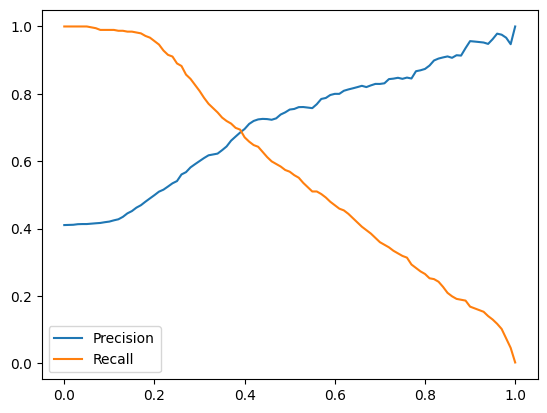

In [25]:
df_scores = p_r_dataframe(y_val, y_pred_val)
plt.plot(df_scores.threshold, df_scores['p'], label='Precision')
plt.plot(df_scores.threshold, df_scores['r'], label='Recall')
plt.legend()

In [26]:
max = df_scores['f1_score'].max()
max
threshold = df_scores[df_scores['f1_score'] == df_scores['f1_score'].max()]['threshold']
threshold

39    0.39
Name: threshold, dtype: float64

In [27]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[interested_features_train].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [28]:
def predict(df, dv, model):
    dicts = df[interested_features_train].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [29]:
n_splits = 5

for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.is_hit.values
        y_val = df_val.is_hit.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.6f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/7 [00:00<?, ?it/s]

C=0.001 0.804 +- 0.013677
C=0.01 0.806 +- 0.010687
C=0.1 0.805 +- 0.009729
C=0.5 0.805 +- 0.009689
C=1 0.805 +- 0.009660
C=5 0.805 +- 0.009653
C=10 0.805 +- 0.009650


In [30]:
###### Fine Tuning ########

In [31]:
interested_features_ft = ['runtime', 'popularity', 'vote_avg','log_budget']
target = ['is_hit']

df_full_ft = df_movies[interested_features_ft]
df_full_train_ft, df_test_ft = train_test_split(df_full_ft,test_size=0.2,random_state=42)
df_train_ft, df_val_ft=train_test_split(df_full_train_ft,test_size=0.25,random_state=42)

print(len(df_full_ft), len(df_train_ft),len(df_val_ft), len(df_test_ft))

y_full_ft = df_movies[target]
y_full_train_ft, y_test_ft = train_test_split(y_full_ft,test_size=0.2,random_state=42)
y_train_ft, y_val_ft=train_test_split(y_full_train_ft,test_size=0.25,random_state=42)

print(len(y_train_ft), len(y_val_ft), len(y_test_ft))

4775 2865 955 955
2865 955 955


In [32]:
dv_log_reg = DictVectorizer()

train_dict_ft = df_train_ft[interested_features_ft].to_dict(orient='records')
X_train_ft = dv_log_reg.fit_transform(train_dict_ft)

val_dict_ft = df_val_ft[interested_features_ft].to_dict(orient='records')
X_val_ft = dv_log_reg.transform(val_dict_ft)

print(len(df_train_ft),len(df_val_ft), len(df_test_ft))
print(len(y_train_ft), len(y_val_ft), len(y_test_ft))
print(len(train_dict_ft), len(val_dict_ft))
print(np.shape(X_train_ft), np.shape(X_val_ft))


2865 955 955
2865 955 955
2865 955
(2865, 4) (955, 4)


In [33]:
best_c = 0.1 ## Arriving at this c from K_Fold
log__ft_reg_model = LogisticRegression(solver='liblinear', C=best_c, max_iter=1000, random_state=42)

param_grid = {
        'C' : [0.001, 0.01, 0.1, 1, 10, 100]
}

grid_search = GridSearchCV(
    estimator = log__ft_reg_model,
    param_grid=param_grid,
    cv=5, 
    scoring='roc_auc',
    verbose=1)

In [34]:
print("Starting GridSearchCV.....")
grid_search.fit(X_train_ft, y_train_ft)
print("GridSearchCV Complete.")

Starting GridSearchCV.....
Fitting 5 folds for each of 6 candidates, totalling 30 fits
GridSearchCV Complete.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/uti

In [35]:
print("Results Analysis")
print(f"Best C Parameter Found: {grid_search.best_params_}")
print(f"Best cross-validation ROC AUC Score: {grid_search.best_score_:.4f}")

Results Analysis
Best C Parameter Found: {'C': 1}
Best cross-validation ROC AUC Score: 0.8052


In [36]:
df_cv_results = pd.DataFrame(grid_search.cv_results_)
cv_result_fields = ['param_C', 'mean_test_score', 'std_test_score', 'rank_test_score']
print("Full Cross Validation Results")
print(df_cv_results[cv_result_fields])

Full Cross Validation Results
   param_C  mean_test_score  std_test_score  rank_test_score
0    0.001         0.780968        0.018832                6
1    0.010         0.784742        0.018426                5
2    0.100         0.799354        0.016126                4
3    1.000         0.805223        0.015208                1
4   10.000         0.804724        0.015922                2
5  100.000         0.804656        0.015973                3


In [37]:
final_classification_model = grid_search.best_estimator_
y_pred_final = final_classification_model.predict(X_val_ft)
y_prob_final = final_classification_model.predict_proba(X_val_ft)[:,1]

In [38]:
f1 = f1_score(y_val_ft, y_pred_final)
auc_val = roc_auc_score(y_val_ft, y_prob_final)
conf_matrix = confusion_matrix(y_val_ft, y_pred_final)
f1, auc_val, conf_matrix

(0.6158445440956651,
 0.8085678902173616,
 array([[492,  77],
        [180, 206]]))

In [39]:
log_reg_final_model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)

In [40]:
log_reg_final_model.fit(X_train_ft, y_train_ft)
y_pred_final_val = log_reg_final_model.predict(X_val_ft)
y_proba_final_val = log_reg_final_model.predict_proba(X_val_ft)[:,1]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [41]:
f1 = f1_score(y_val_ft, y_pred_final_val)
auc_val = roc_auc_score(y_val_ft, y_proba_final_val)
conf_matrix = confusion_matrix(y_val_ft, y_pred_final_val)
f1, auc_val, conf_matrix

(0.6158445440956651,
 0.8085678902173616,
 array([[492,  77],
        [180, 206]]))

In [43]:
with open('_models/classification_model.bin', 'wb') as f_out:
    pickle.dump((final_classification_model, dv_log_reg), f_out)